# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


In [1]:
import os
import requests
from zipfile import ZipFile
import glob
import re

import cv2
import random
import numpy as np

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
#from encoder import DataEncoder
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

# <font style="color:purple">Download the Dataset</font>

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it.

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

In [2]:
def download_file(url, save_name):
    """
    "Download and save the file."

    arguments:
    url (str): URL path of the file.
    save_name: (str): file path to save the downloaded file.
    """
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)
    print(f"Downloaded {save_name}...")
    return

In [3]:
def unzip(zip_file_path=None):
    """
    "Unzip the file"

    arguments:
    zip_file_path (str): The zipped file path

    """
    try:
        with ZipFile(zip_file_path) as z:
            z.extractall("./")
            print(f"Extracted {zip_file_path}...\n")
    except:
        print("Invalid file")

    return

In [4]:
if not os.path.exists('Dataset'):
    download_file(
                  'https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1',
                  'Dataset.zip'
                 )

    unzip('Dataset.zip')


if not os.path.exists('./encoder.py'):
    download_file(
                  'https://www.dropbox.com/s/m1dod6hyaup6o7m/encoder_decoder.zip?dl=1',
                  'encoder_decoder.zip'
                 )

    unzip('encoder_decoder.zip')

Downloaded Dataset.zip...
Extracted Dataset.zip...

Downloaded encoder_decoder.zip...
Extracted encoder_decoder.zip...



In [5]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/yolov9c_predict_video.mp4'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
# # import os

# for dirname, dirnames, filenames in os.walk('/kaggle/working/runs/detect/yolov9c_predict_videos1'):
#     # Print only directories
#     for subdirname in dirnames:
#         print(os.path.join(dirname, subdirname))
# # /kaggle/working/output1.jpg
# /kaggle/working/Dataset.zip
# /kaggle/working/vehicle_det.yaml
# /kaggle/working/yolov9c.pt
# /kaggle/working/yolov8n.pt
# /kaggle/working/train_boxes.csv
# /kaggle/working/output2.jpg
# /kaggle/working/encoder_decoder.zip
# /kaggle/working/Project 3 Sample Input Video.mp4
# /kaggle/working/output0.jpg
# /kaggle/working/encoder.py

In [6]:
#current_directory = os.getcwd()

In [7]:
#current_directory
#  /kaggle/working/Dataset/train/Vehicle registration plate/124c06d8f5b23f3f.jpg

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font>

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [8]:

#plt.figure(figsize = (15,10))

def load_image(l_filepath,im_filepath, num_samples ):
    label_file = os.path.join(root_dir,l_filepath)

    im_filepath = os.path.join(root_dir,im_filepath)

    all_images = glob.glob(im_filepath +'*.jpg')
    all_images.sort()
    num_images = len(all_images)
   
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = all_images[j]
        image_name = ('.'.join(image.split(os.path.sep)[-1].split('.')[:-1]))
        image = cv2.imread(image)
        label_path = label_file + image_name +'.txt'
        #Regular expression pattern to match the label
        pattern = r'^Vehicle registration plate'
#        pattern = r'^Vehicle registration plate'|r'^0.0'
        label_len = len(pattern) - 1
        bboxes = []
        labels = []
        with open(label_path,'r') as f:
            label_lines = f.readlines()
            plt.figure(figsize=(20, 20))
            for label_line in label_lines:
                # Extract label using regular expression
                label = re.match(pattern, label_line).group()
                xmin, ymin, xmax, ymax = label_line[label_len:].split()
                xmin = float(xmin)
                ymin = float(ymin)
                xmax = float(xmax)
                ymax = float(ymax)
              
                bboxes.append([xmin,ymin,xmax,ymax])
                labels.append(label)
        result_image = plot_image(image,bboxes,labels)
        plt.subplot(3, 1, i+1)
        plt.imshow(result_image[:, :, ::-1])
    #    plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

   


In [9]:
def plot_image(image,bboxes,labels):
    h, w,_ = image.shape
    thickness = max(2, int(w/275))
    for box_num, box in enumerate(bboxes):
        x1,y1,x2,y2 = box
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        cv2.rectangle(image, (x1,y1), (x2,y2),  (255, 0, 0)[::-1],  thickness)
        
        cv2.putText(image, 'reg-plate', org = (x1,y1-5),
                   fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.5,
                    color=(0,255,0)[::-1],
                    thickness=2,
                    lineType=cv2.LINE_AA)
    return image

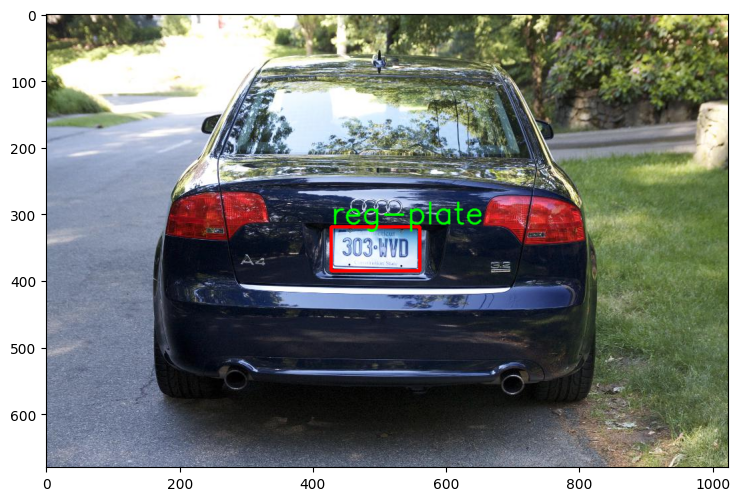

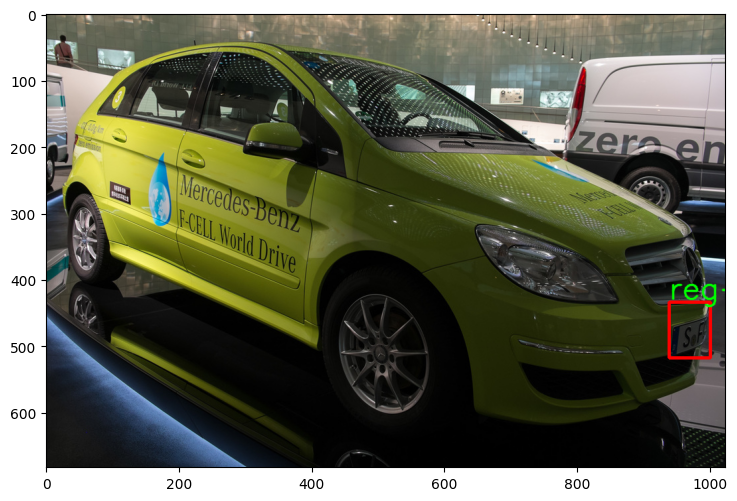

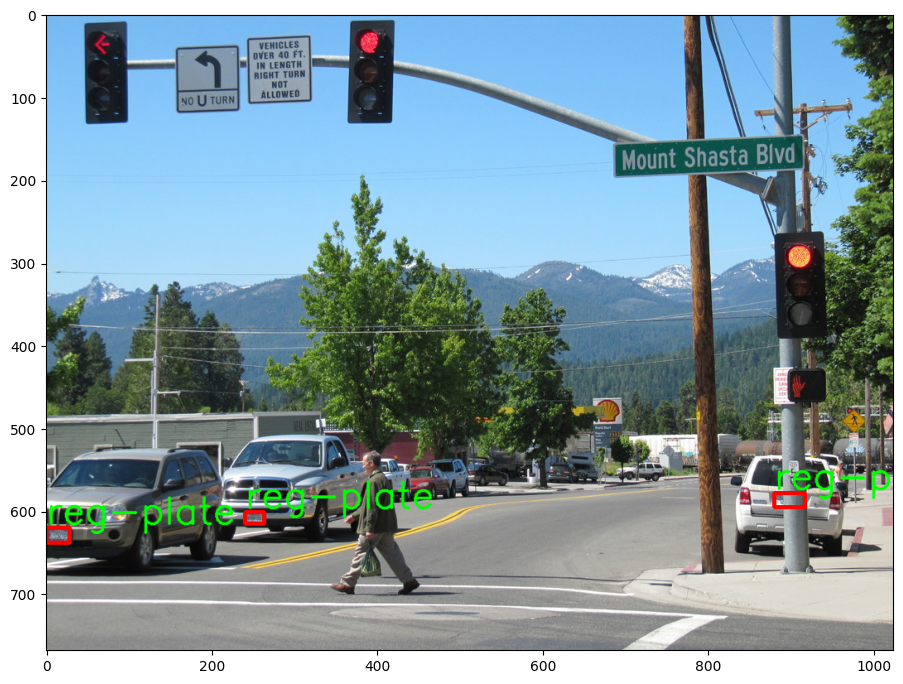

In [10]:
root_dir = '/kaggle/working/Dataset'
l_filepath = 'validation/Vehicle registration plate/Label/'
im_filepath = 'validation/Vehicle registration plate/'

load_image(l_filepath ,im_filepath, 3)

#  <font style="color:green">2. Training [25 Points]</font>

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.**

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

Our labels are in xmin, ymin, xmax, ymax format. Inorder to use in YOLO, we need to convert that to YOLO format (xcenter,ycenter, width, height) and normalize them.

In [11]:
class_names = {
    "Vehicle registration plate" : 0
}

In [12]:
def get_bbox_cord(l_filepath,im_filepath):
    all_images =[]
    label_file = os.path.join(root_dir,l_filepath)

    im_filepath = os.path.join(root_dir,im_filepath)

    all_images.extend(glob.glob(im_filepath +'*.jpg'))
    all_images.extend(glob.glob(im_filepath +'*.JPG'))
    
    all_images.sort()
    num_images = len(all_images)
    
    bboxes = []
    labels = []
    image_names = []
    sum = 0
    
    pattern = r'^Vehicle registration plate'
    count = 0
    for id,image in enumerate(all_images):
        
        bboxes_per_image = []
        labels_per_image = []
        #get the image names from each dir and append to list
        image_name = ('.'.join(image.split(os.path.sep)[-1].split('.')[:-1]))
        image_names.append(image_name)
        
        image = cv2.imread(image)
        height,width,_ = image.shape 
    
        label_path = label_file + image_name +'.txt'
        with open(label_path,'r') as f:
            label_lines = f.readlines()
            sum+=len(label_lines)  #total num of labels
            
            for label_line in label_lines:
                #Labels
                label = re.match(pattern, label_line).group()
                label_len = len(label)
                label = class_names[label]
                labels_per_image.append([int(label)])
                #Bounding box
                xmin, ymin, xmax, ymax = label_line[label_len:].split()
                xmin = float(xmin)
                xmax = float(xmax)
                ymin = float(ymin)
                ymax = float(ymax)                
                #convert to YOLO format
                
                x_center, y_center,width_n,height_n = conversion(xmin, ymin, xmax, ymax,height,width,count)

                bboxes_per_image.append([x_center, y_center,width_n,height_n])
                
        bboxes.append(bboxes_per_image)
        labels.append(labels_per_image)
 
    return labels,bboxes,all_images,image_names

In [13]:

def conversion(xmin, ymin, xmax, ymax, img_height,img_width,count ):
    x_center,y_center,width,height = 0,0,0,0

    x_center = xmin + ((xmax-xmin)/2)
    y_center = ymin + ((ymax-ymin)/2)
    width = xmax - xmin
    height = ymax - ymin
    #Normalize 
    x_center = x_center/img_width
    y_center = y_center/img_height
    width = width/img_width
    height = height/img_height
    return x_center,y_center,width,height

In [14]:
root_dir = '/kaggle/working/Dataset'
l_filepath = 'train/Vehicle registration plate/Label/'
im_filepath = 'train/Vehicle registration plate/'

labels,bboxes,all_images,image_names = get_bbox_cord(l_filepath,im_filepath)


In [15]:
root_dir = '/kaggle/working/Dataset'
l_filepath = 'validation/Vehicle registration plate/Label/'
im_filepath = 'validation/Vehicle registration plate/'

labels2,bboxes2,all_images2,image_names2 = get_bbox_cord(l_filepath,im_filepath)


In [16]:
len(labels2)

386

In [17]:
#Make directories for YOLO
root_dir = '/kaggle/working/'
if not os.path.exists(os.path.join(root_dir,'Vehicle_Registration_Plate')):
    os.makedirs(os.path.join(root_dir,'Vehicle_Registration_Plate'))

    os.makedirs('/kaggle/working/Vehicle_Registration_Plate/train')
    os.makedirs('/kaggle/working/Vehicle_Registration_Plate/train/images')
    os.makedirs('/kaggle/working/Vehicle_Registration_Plate/train/labels')
    
    os.makedirs('/kaggle/working/Vehicle_Registration_Plate/validation')
    os.makedirs('/kaggle/working/Vehicle_Registration_Plate/validation/images')
    os.makedirs('/kaggle/working/Vehicle_Registration_Plate/validation/labels')
        
    

In [18]:
import shutil as sh
for id,image_name in enumerate(image_names):
    image_path = all_images[id]
    name = ('.'.join(image_path.split(os.path.sep)[-1].split('.')[:-1]))
    if image_name == name:
        source = all_images[id]
        dest = '/kaggle/working/Vehicle_Registration_Plate/train/images/{}.jpg'.format(name)
        sh.copy(source,dest)
        filepath = '/kaggle/working/Vehicle_Registration_Plate/train/labels/{}.txt'.format(name)
        with open(filepath,'w+') as f:
            label = np.concatenate((labels[id],bboxes[id]),axis = 1)
            label = label.astype(str)
            for row in label:
                txt = ' '.join(row)
                f.write(txt)
                f.write('\n')


In [19]:
import shutil as sh
for id,image_name in enumerate(image_names2):
    image_path = all_images2[id]
    name = ('.'.join(image_path.split(os.path.sep)[-1].split('.')[:-1]))
    if image_name == name:
        source = all_images2[id]
        dest = '/kaggle/working/Vehicle_Registration_Plate/validation/images/{}.jpg'.format(name)
        sh.copy(source,dest)
        filepath = '/kaggle/working/Vehicle_Registration_Plate/validation/labels/{}.txt'.format(name)
        with open(filepath,'w+') as f:
            label = np.concatenate((labels2[id],bboxes2[id]),axis = 1)
            label = label.astype(str)
            for row in label:
                txt = ' '.join(row)
                f.write(txt)
                f.write('\n')


Let's check few images

In [20]:

#plt.figure(figsize = (15,10))

def load_image(l_filepath,im_filepath, num_samples ):
    label_file = os.path.join(root_dir,l_filepath)

    im_filepath = os.path.join(root_dir,im_filepath)

    all_images = glob.glob(im_filepath +'*.jpg')
    all_images.sort()
    num_images = len(all_images)
   
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = all_images[j]
        image_name = ('.'.join(image.split(os.path.sep)[-1].split('.')[:-1]))
        image = cv2.imread(image)
        height,width,_ = image.shape
        label_path = label_file + image_name +'.txt'
        #Regular expression pattern to match the label
        pattern = r'^0.0'
#        pattern = r'^Vehicle registration plate'|r'^0.0'
        label_len = len(pattern) - 1
        bboxes = []
        bboxes_c = []
        labels = []
        with open(label_path,'r') as f:
            label_lines = f.readlines()
            print(len(label_lines))
            plt.figure(figsize=(20, 20))
            for label_line in label_lines:
                # Extract label using regular expression
                label = re.match(pattern, label_line).group()
                #print(label)
                x_c, y_c, w, h = label_line[label_len:].split()
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes_c.append([x_c,y_c,w,h])
               # print(bboxes_c)
                for box_num, box in enumerate(bboxes_c):
                    xmin,ymin,xmax,ymax = yolo2bbox(box)
                    #denormalize
                    xmin = xmin*width
                    ymin = ymin*height
                    xmax = xmax*width
                    ymax = ymax*height
                    bboxes.append([xmin,ymin,xmax,ymax])
                labels.append(label)
        result_image = plot_image(image,bboxes,labels)
        plt.subplot(3, 1, i+1)
        plt.imshow(result_image[:, :, ::-1])
    #    plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


In [21]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

1
2
1


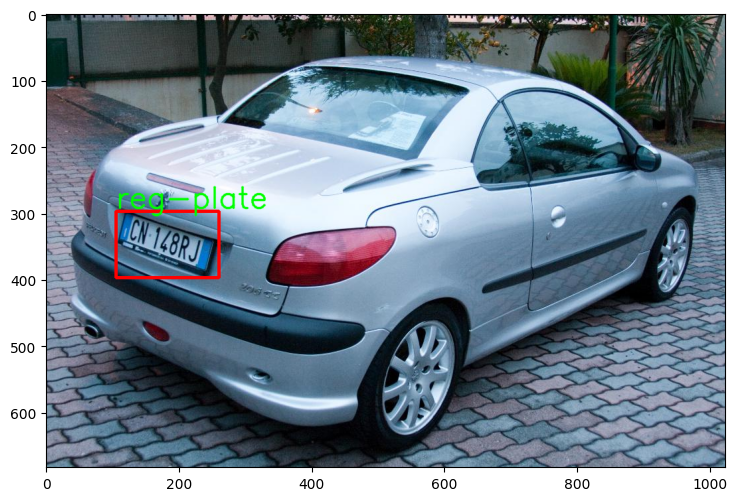

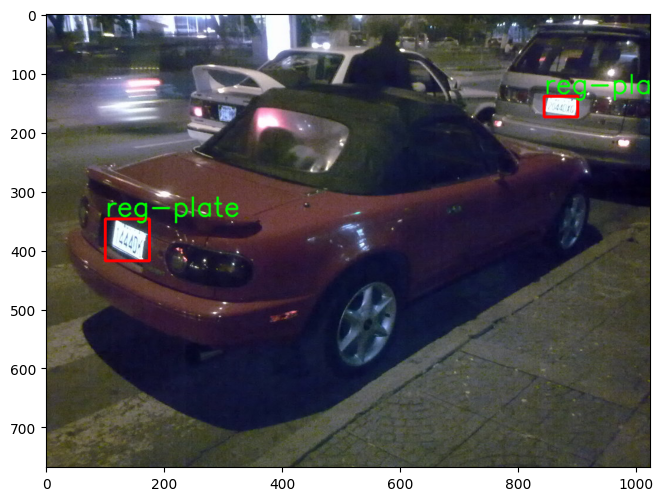

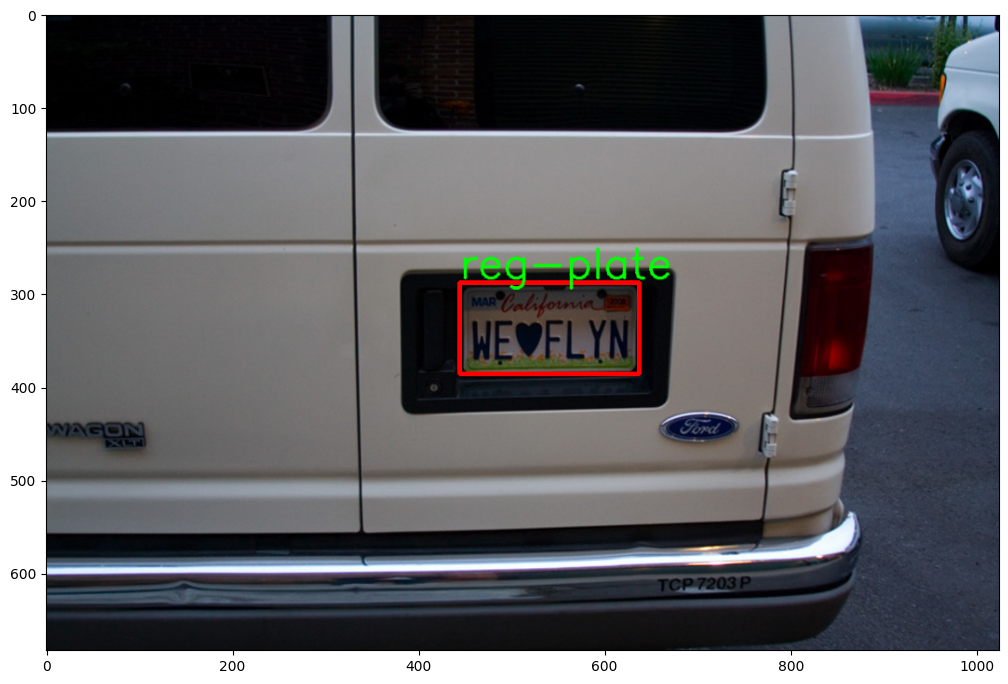

In [22]:
root_dir = '/kaggle/working/Vehicle_Registration_Plate'
l_filepath = 'validation/labels/'
im_filepath = 'validation/images/'

load_image(l_filepath ,im_filepath, 3)

In [23]:
#Model YAML file
import yaml

attr = {
    'path' : root_dir,
    'train' : root_dir+'/train/images',
    'val' : root_dir+'/validation/images',
    'nc': 1,
    'name' : {
            0.0:'Vehicle registration plate'
    }
}

In [24]:
with open('vehicle_det.yaml','w') as f:
    yaml.dump(attr,f)
    

In [25]:
# #load tensorboard
%load_ext tensorboard
%tensorboard --logdir 'runs/detect/' 

Yolov9

In [26]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.9/756.9 kB 14.6 MB/s eta 0:00:00a 0:00:01


In [27]:
from ultralytics import YOLO
#91.7 yolov9c for 30 epochs
#build a yolov9c from pretrained weight
model = YOLO('yolov9c.pt')

#display model information
model.info()

#train the model for 100 epochs on our dataset
results = model.train(data = 'vehicle_det.yaml', epochs = 30,imgsz = 640)



100%|██████████| 49.4M/49.4M [00:00<00:00, 213MB/s] 


YOLOv9c summary: 618 layers, 25590912 parameters, 0 gradients, 104.0 GFLOPs
Ultralytics YOLOv8.2.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=vehicle_det.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
2024-05-14 04:13:46,235	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-14 04:13:47,428	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-14 04:13:48.222082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 04:13:48.222140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 04:13:48.223401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 46.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Vehicle_Registration_Plate/train/labels... 5308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5308/5308 [00:04<00:00, 1305.76it/s]


train: New cache created: /kaggle/working/Vehicle_Registration_Plate/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/Vehicle_Registration_Plate/validation/labels... 386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 386/386 [00:00<00:00, 1223.65it/s]

val: New cache created: /kaggle/working/Vehicle_Registration_Plate/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.1G      1.629      1.612      1.361         21        640: 100%|██████████| 332/332 [04:16<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        386        512      0.427      0.388      0.296      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.2G      1.778      1.423      1.416         25        640: 100%|██████████| 332/332 [04:12<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512       0.56       0.49      0.472      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      11.2G      1.731      1.354      1.373         21        640: 100%|██████████| 332/332 [04:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]

                   all        386        512       0.82      0.668      0.738      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      11.1G      1.665      1.249      1.338         19        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]

                   all        386        512      0.819      0.758      0.802      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      11.1G      1.598      1.127      1.295         25        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

                   all        386        512      0.777      0.781      0.807      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.2G      1.556      1.075      1.272         31        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        386        512      0.883       0.76      0.832       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      11.5G      1.555       1.05      1.267         40        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]

                   all        386        512      0.842      0.783      0.836      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      11.5G      1.507     0.9987      1.244         36        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

                   all        386        512      0.908      0.791      0.856      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      11.5G        1.5     0.9727      1.244         41        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512        0.9      0.788      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      11.5G      1.463     0.9187      1.218         22        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

                   all        386        512      0.868      0.793      0.862      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      11.2G      1.468     0.9182      1.238         30        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512      0.894      0.806       0.87      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      11.2G      1.436      0.889      1.208         29        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        386        512      0.909      0.811      0.876      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      11.5G      1.411     0.8606      1.193         34        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512      0.901      0.814      0.878      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      11.5G      1.404     0.8505        1.2         37        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        386        512      0.906      0.838      0.888      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      11.5G      1.397     0.8363      1.193         29        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]

                   all        386        512       0.89      0.836      0.892      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.5G       1.39     0.8089      1.186         30        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.17it/s]

                   all        386        512      0.915      0.838      0.899      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.5G      1.372      0.805       1.18         23        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

                   all        386        512      0.932      0.836      0.895      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      11.5G      1.364     0.7895      1.178         33        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        386        512      0.925      0.846      0.883      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      11.5G      1.356     0.7761      1.167         19        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512      0.913      0.857      0.893      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      11.1G      1.368     0.7435      1.185         14        640: 100%|██████████| 332/332 [04:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]

                   all        386        512      0.927      0.844      0.896      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      11.2G      1.353     0.7173      1.176         15        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

                   all        386        512      0.906      0.851      0.904       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      11.3G      1.338     0.7059      1.167         15        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

                   all        386        512      0.909      0.861      0.907      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      11.5G      1.323     0.6941      1.155         16        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]

                   all        386        512      0.937      0.848      0.916      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      11.5G      1.307     0.6735       1.15         18        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

                   all        386        512      0.915      0.865      0.898      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      11.5G      1.295     0.6571      1.147         19        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512      0.912      0.877      0.911      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      11.5G      1.277     0.6406      1.143         14        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        386        512       0.92       0.88      0.917       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      11.2G      1.271     0.6358       1.14         17        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512      0.916      0.877      0.914      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      11.5G      1.248     0.6187      1.125         19        640: 100%|██████████| 332/332 [04:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        386        512      0.926      0.869      0.917      0.685



30 epochs completed in 2.145 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


                   all        386        512      0.926      0.869      0.917      0.684
Speed: 0.1ms preprocess, 11.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


#  <font style="color:green">3. Inference [15 Points]</font>

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




In [28]:
root_dir = '/kaggle/working/Vehicle_Registration_Plate'
l_filepath = 'validation/labels/'
im_filepath = 'validation/images/'

In [29]:
from PIL import Image
def detections(images):
    result = model(images)

    for i, result in enumerate(result):
        #plot result images
        im_bgr = result.plot()  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

        plt.axis('off')
        plt.imshow(im_rgb)
        plt.show()
        xyxy = result[0].boxes.xyxy[0]
        x1, y1, x2, y2 = map(float, xyxy)
        cls = int(result[0].boxes.cls[0])
        conf = float(result[0].boxes.conf[0])
        print("x1: ", x1, "y1: ", y1, "x2: ", x2, "y2: ", y2, "cls: ", cls, "conf: ", conf)
   # for result in result[0].boxes:
        
        
    
        
        # Save results to disk
     #   result.save(filename=f'output{i}.jpg')


0: 640x640 1 class_0, 48.6ms
1: 640x640 1 class_0, 48.6ms
2: 640x640 1 class_0, 48.6ms
Speed: 2.8ms preprocess, 48.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


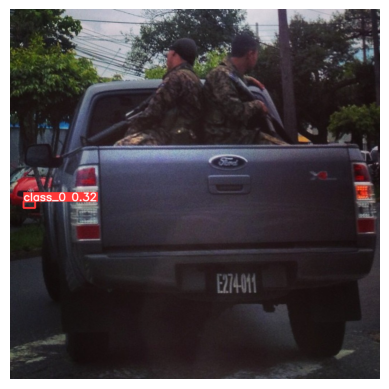

x1:  37.747840881347656 y1:  532.3792114257812 x2:  69.54357147216797 y2:  550.2344970703125 cls:  0 conf:  0.32007303833961487


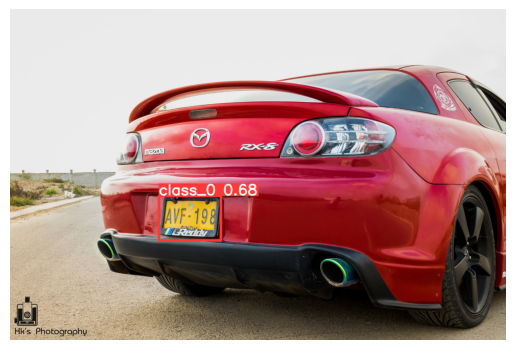

x1:  307.4274597167969 y1:  385.49249267578125 x2:  435.1560974121094 y2:  477.67120361328125 cls:  0 conf:  0.6812507510185242


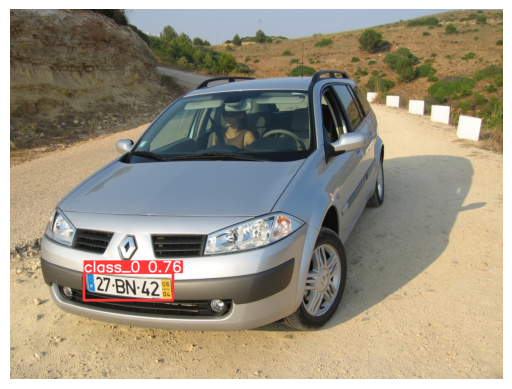

x1:  153.48281860351562 y1:  547.3572387695312 x2:  338.3353576660156 y2:  604.6083984375 cls:  0 conf:  0.7556449174880981


In [30]:
num_samples = 3
test_images = []
for i in range(num_samples):
    im = random.choice(image_names2)
    im_path = os.path.join(root_dir,im_filepath)+im+'.jpg'
    test_images.append(im_path)
detections(test_images)

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font>

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



In [44]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
print("map ",metrics.box.map)    # map50-95
print("map50 ", metrics.box.map50)  # map50
print("map75 ",metrics.box.map75)  # map75
print("maps50-95 ",metrics.box.maps)   # a list contains map50-95 of each category

Ultralytics YOLOv8.2.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/Vehicle_Registration_Plate/validation/labels.cache... 386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 386/386 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


                   all        386        512      0.928      0.869      0.917      0.685
Speed: 0.2ms preprocess, 24.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train4
map  0.6846835531785074
map50  0.916618003272932
map75  0.8126096142676082
maps50-95  [    0.68468]


In [32]:


# def prepare_pred(im_filepath):
#     path = os.path.join(root_dir,im_filepath)
#     pred = []
#     for i in image_names2:
#         im_file = path+i+'.jpg'
#         pred_results=model(im_file)[0].boxes.cpu()
#         pred_dict = dict(
#                         # Predictions boxes in (xmin, ymin, xmax, ymax) format.
#                         boxes  = pred_results.xyxy, 
#                         # Confidence scores.
#                         scores = pred_results.conf, 
#                         # Class labels.
#                         labels = pred_results.cls.type(torch.int))
#     pred.append(pred_dict)
#     return pred
# predictions = prepare_pred(im_filepath)        

In [33]:
# def prepare_target(bboxes2,labels2):
#     targets = []
#     boxes_tensor = torch.tensor(bboxes2, dtype = torch.float)
#     labels_tensor = torch.tensor(labels2, dtype = torch.int)
#     gt = dict(
#         boxes  = bboxes2,
#          labels = labels2
#                                 )
#     targets.append(gt)
#     return targets
# targets = prepare_target(bboxes2,labels2)

In [34]:
# pip install torchmetrics[detection]

In [35]:
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
# # Initalize the MeanAveragePrecision class.
# map_evaluator = MeanAveragePrecision(class_metrics=True)
# # Pass the predictions and targets data.
# map_evaluator.update(predictions, targets)

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.**

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

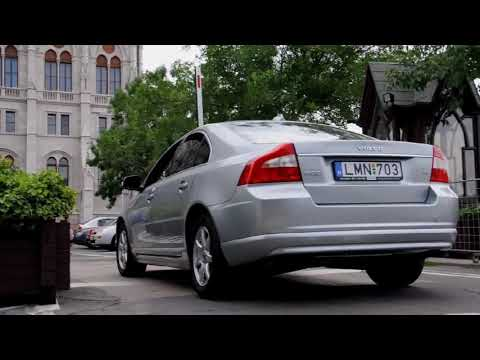

In [36]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

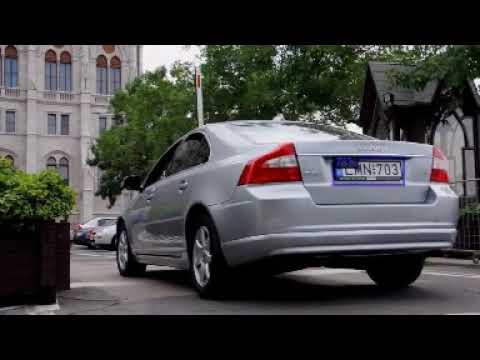

In [37]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

In [38]:
pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
from pytube import YouTube

# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=18HWHCevFdU'

# Download the video
yt = YouTube(video_url)
stream = yt.streams.filter(file_extension='mp4').first()
stream.download('/kaggle/working')


'/kaggle/working/Project 3 Sample Input Video.mp4'

**You can use the following sample code to read and write a video.**

In [40]:
video_path ='/kaggle/working/Project 3 Sample Input Video.mp4'
# video_read_write(video_path)

In [41]:
#yt_link = 'https://youtu.be/18HWHCevFdU'
results = model(video_path, stream=True, save= True ,)

In [42]:
#when stream = True, output iis a generator. 
#Stepping through the outputted results generator object using next() will execute the intended functionality (e.g. run inference and save output) on each iteration
for r in results:
    next(results)


video 1/1 (frame 1/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 122.9ms
video 1/1 (frame 2/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 31.4ms
video 1/1 (frame 3/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 31.3ms
video 1/1 (frame 4/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 31.3ms
video 1/1 (frame 5/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 31.4ms
video 1/1 (frame 6/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 31.3ms
video 1/1 (frame 7/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 18.9ms
video 1/1 (frame 8/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 18.5ms
video 1/1 (frame 9/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 18.4ms
video 1/1 (frame 10/131) /kaggle/working/Project 3 Sample Input Video.mp4: 384x640 1 class_0, 18.4

StopIteration: 

In [45]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/runs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/runs/detect/train3/Project 3 Sample Input Video.avi
/kaggle/working/runs/detect/train/results.png
/kaggle/working/runs/detect/train/args.yaml
/kaggle/working/runs/detect/train/train_batch6641.jpg
/kaggle/working/runs/detect/train/labels_correlogram.jpg
/kaggle/working/runs/detect/train/train_batch2.jpg
/kaggle/working/runs/detect/train/val_batch0_labels.jpg
/kaggle/working/runs/detect/train/P_curve.png
/kaggle/working/runs/detect/train/val_batch0_pred.jpg
/kaggle/working/runs/detect/train/confusion_matrix.png
/kaggle/working/runs/detect/train/train_batch6640.jpg
/kaggle/working/runs/detect/train/F1_curve.png
/kaggle/working/runs/detect/train/train_batch6642.jpg
/kaggle/working/runs/detect/train/val_batch2_pred.jpg
/kaggle/working/runs/detect/train/labels.jpg
/kaggle/working/runs/detect/train/val_batch1_labels.jpg
/kaggle/working/runs/detect/train/PR_curve.png
/kaggle/working/runs/detect/train/train_batch1.jpg
/kaggle/working/runs/detect/train/val_batch2_labels.jpg
/kagg

In [46]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('runs/detect/train3/Project 3 Sample Input Video.avi')

/kaggle/working


/kaggle/working/runs/detect/train3/Project 3 Sample Input Video.avi

In [52]:
from PIL import Image
def graphs(path):
    image = Image.open(path)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

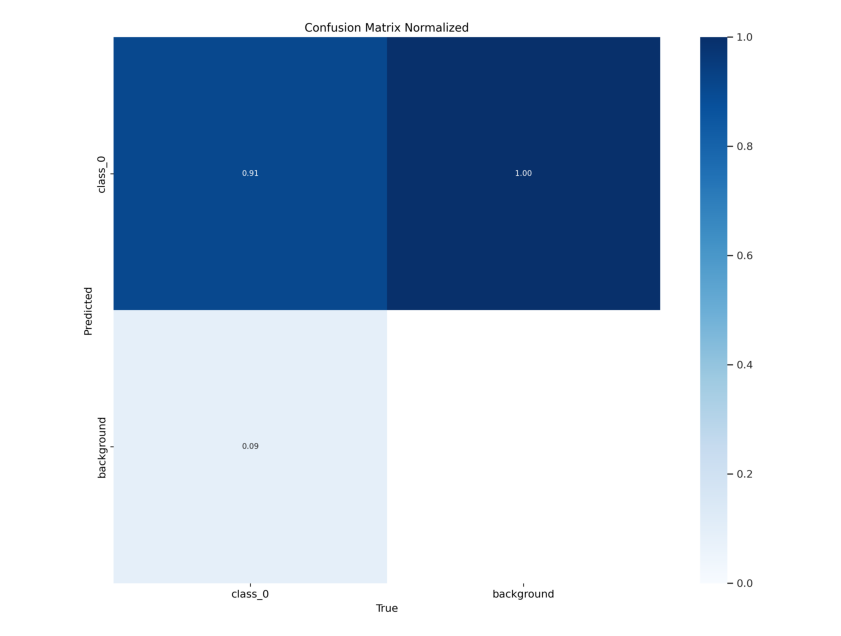

In [63]:
path = '/kaggle/working/runs/detect/train4/confusion_matrix_normalized.png'
graphs(path)

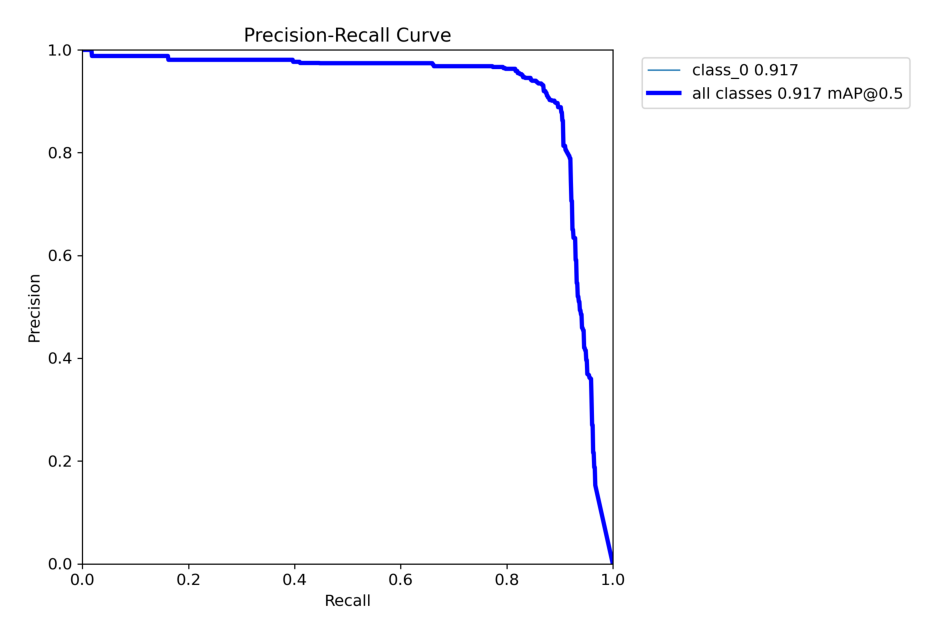

In [57]:
path = ('/kaggle/working/runs/detect/train4/PR_curve.png')
graphs(path)


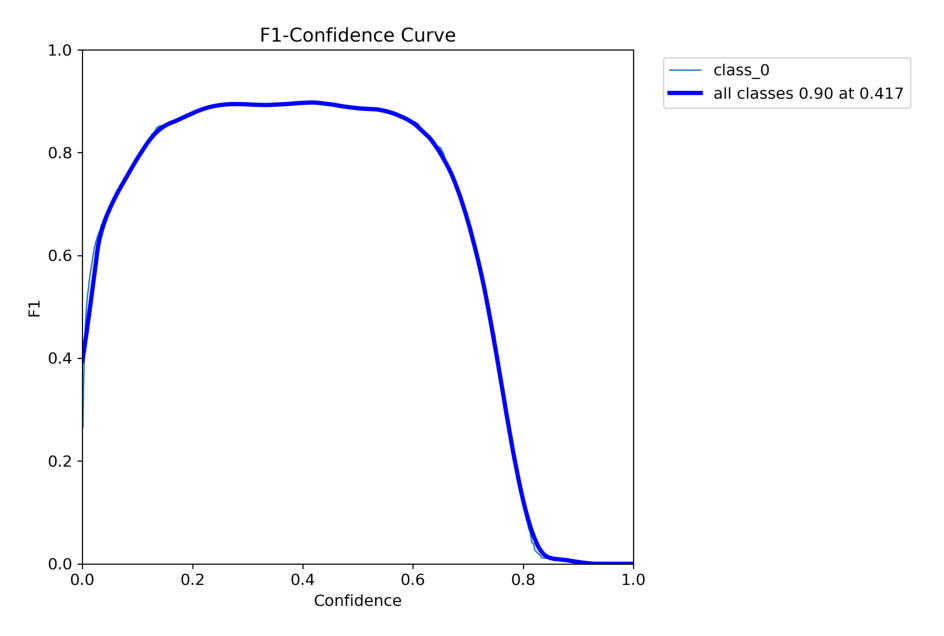

In [58]:
path = '/kaggle/working/runs/detect/train4/F1_curve.png'
graphs(path)

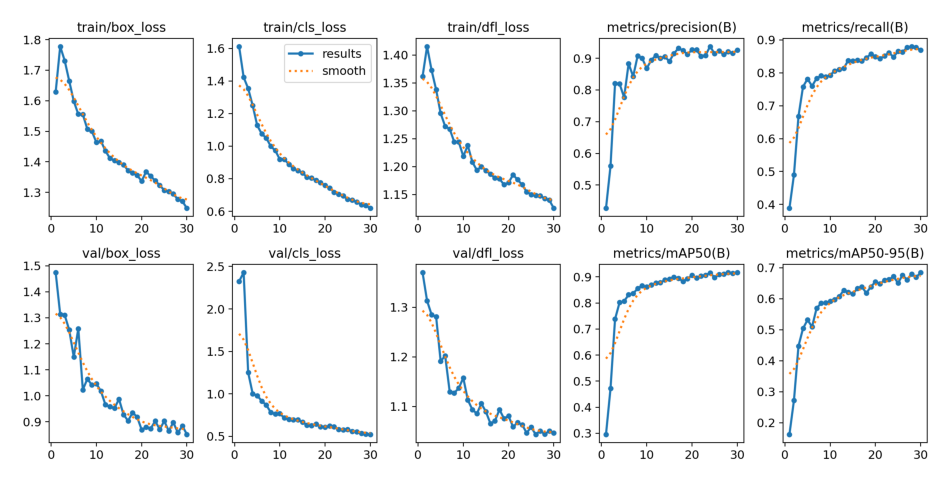

In [59]:
path = '/kaggle/working/runs/detect/train/results.png'
graphs(path)

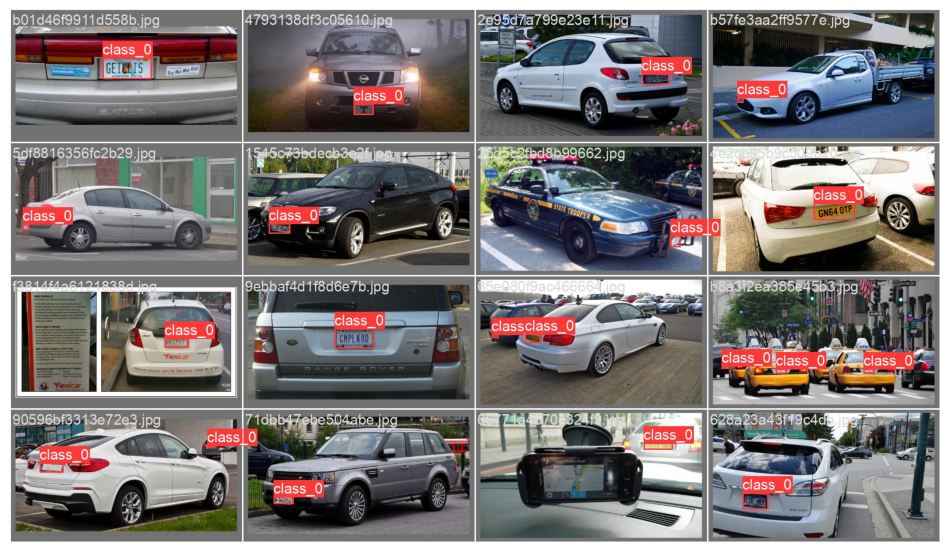

In [64]:
path = '/kaggle/working/runs/detect/train4/val_batch0_labels.jpg'
graphs(path)

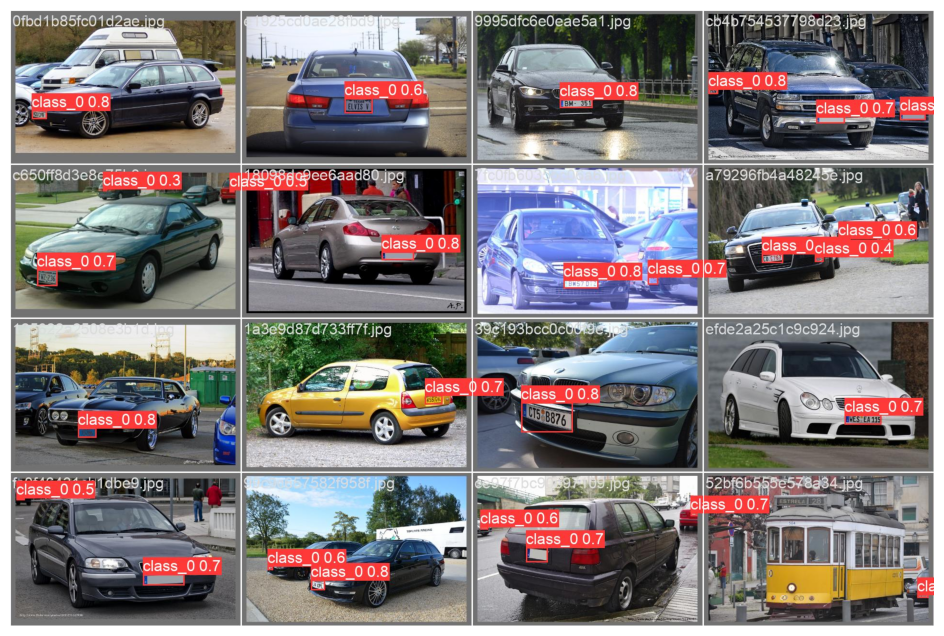

In [67]:
path = '/kaggle/working/runs/detect/train4/val_batch2_pred.jpg'
graphs(path)

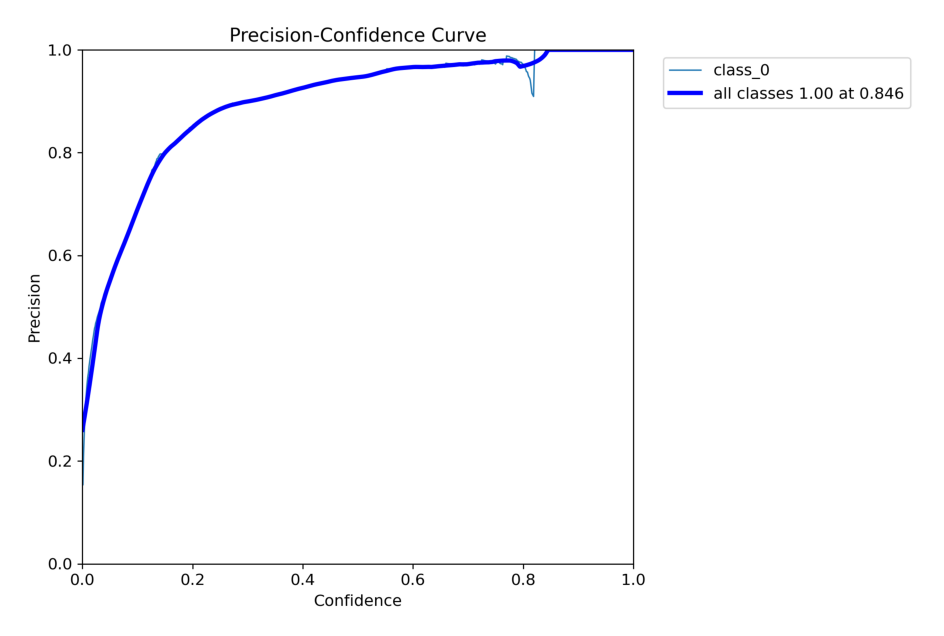

In [65]:
path = '/kaggle/working/runs/detect/train4/P_curve.png'
graphs(path)

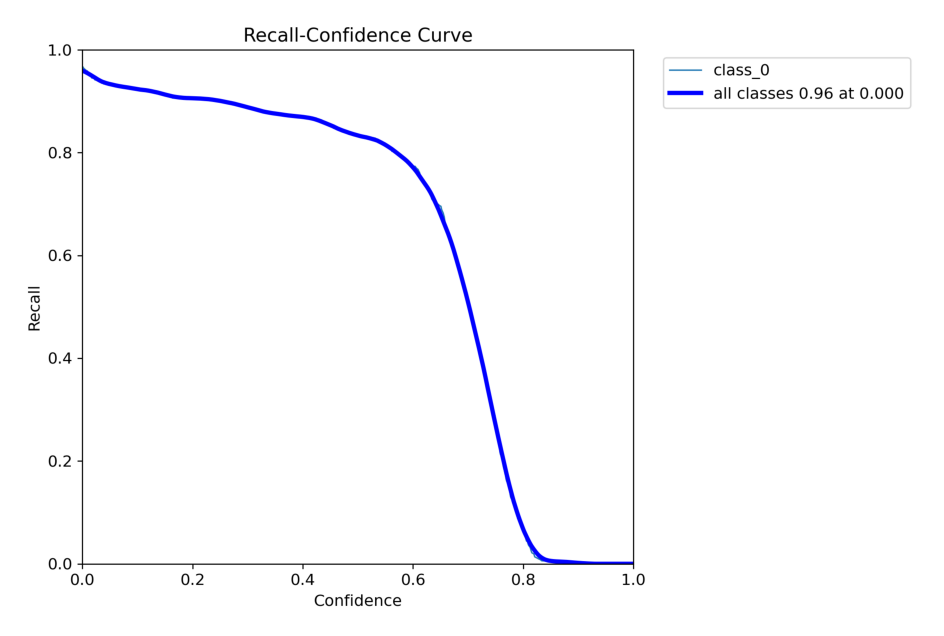

In [66]:
path = '/kaggle/working/runs/detect/train4/R_curve.png'
graphs(path)

You can view the logs here:
https://api.wandb.ai/links/student_smruthi/0oaasbuc

Youtube link:
    https://www.youtube.com/watch?v=Io2EJXMALHs